# Project 2: Causality, RCTs and two-sample tests

```
From ML Theory to Practice
Universität Potsdam, fall semester 2025

Authors: Juan L. Gamella and Simon Bing
License: CC-BY-4.0 https://creativecommons.org/licenses/by/4.0/
```

## Setup

These packages should already be installed in your Python virtual environment.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Connect to the Remote Lab

We will use the queue system for this project. Let's start the connection to the Remote Lab.

In [3]:
import causalchamber.lab as lab
rlab = lab.Lab(credentials_file = '/home/matteo/Desktop/Uni/canton.credentials')


Fetching list of available datasets from
  https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.


Citation
--------

If you use our datasets, simulators or Remote Lab for your work, please consider citing:

﻿@article{gamella2025chamber,
  author={Gamella, Juan L. and Peters, Jonas and B{"u}hlmann, Peter},
  title={Causal chambers as a real-world physical testbed for {AI} methodology},
  journal={Nature Machine Intelligence},
  doi={10.1038/s42256-024-00964-x},
  year={2025},
}


Support & feedback
------------------

If you encounter bugs o have feedback, please write us an email at

  support@causalchamber.ai

or leave an issue at

  https://github.com/juangamella/causal-chamber-package/issues

If you are a Remote Lab subscriber, contact us directly through any of
the provided support channels.



Chambers

  Status   Chamber ID     Model              Mode    Valid Configurations  
─────────────────────────────────────────────────────────────────

### Helper functions

You can use the following helper function to monitor the completion of a list of experiments and download their data.

In [4]:
import time
def wait_and_download(ids, download_dir):
    """
    Given a list of experiment ids, wait for them to complete and download the data.
    """
    dataframes = []
    spinner = ['⠋', '⠙', '⠹', '⠸', '⠼', '⠴', '⠦', '⠧', '⠇', '⠏']
    print(f"Waiting for data from {len(ids)} experiment{'s' if len(ids) else ''}")
    for j,experiment_id in enumerate(ids):
        data = None        
        i = 0
        while data is None:
            try:
                data = rlab.download_data(experiment_id = experiment_id, root=download_dir)          
            except lab.exceptions.UserError:
                print(f"  ({j+1}/{len(ids)}) waiting for {experiment_id} to finish {spinner[i]}", end='\r')
                i = (i+1) % len(spinner)            
        # Clear the line and return the data
        print(f"  ({j+1}/{len(ids)}) downloaded {experiment_id}                     ")
        dataframes.append(data.dataframe)
    return dataframes

And you can use this function to cancell all your currently queued experiments

In [5]:
def cancel_all():
    """
    Cancel all your queued experiments.
    """
    for experiment in rlab.get_experiments(verbose=False):
        if experiment['status'] == 'QUEUED':
            try:
                rlab.cancel_experiment(experiment['experiment_id'])
            except UserError:
                continue

## Performing a controlled experiment


We will begin by performing a simple controlled experiment to test the effect of the light source brightness on the other variables of the system.

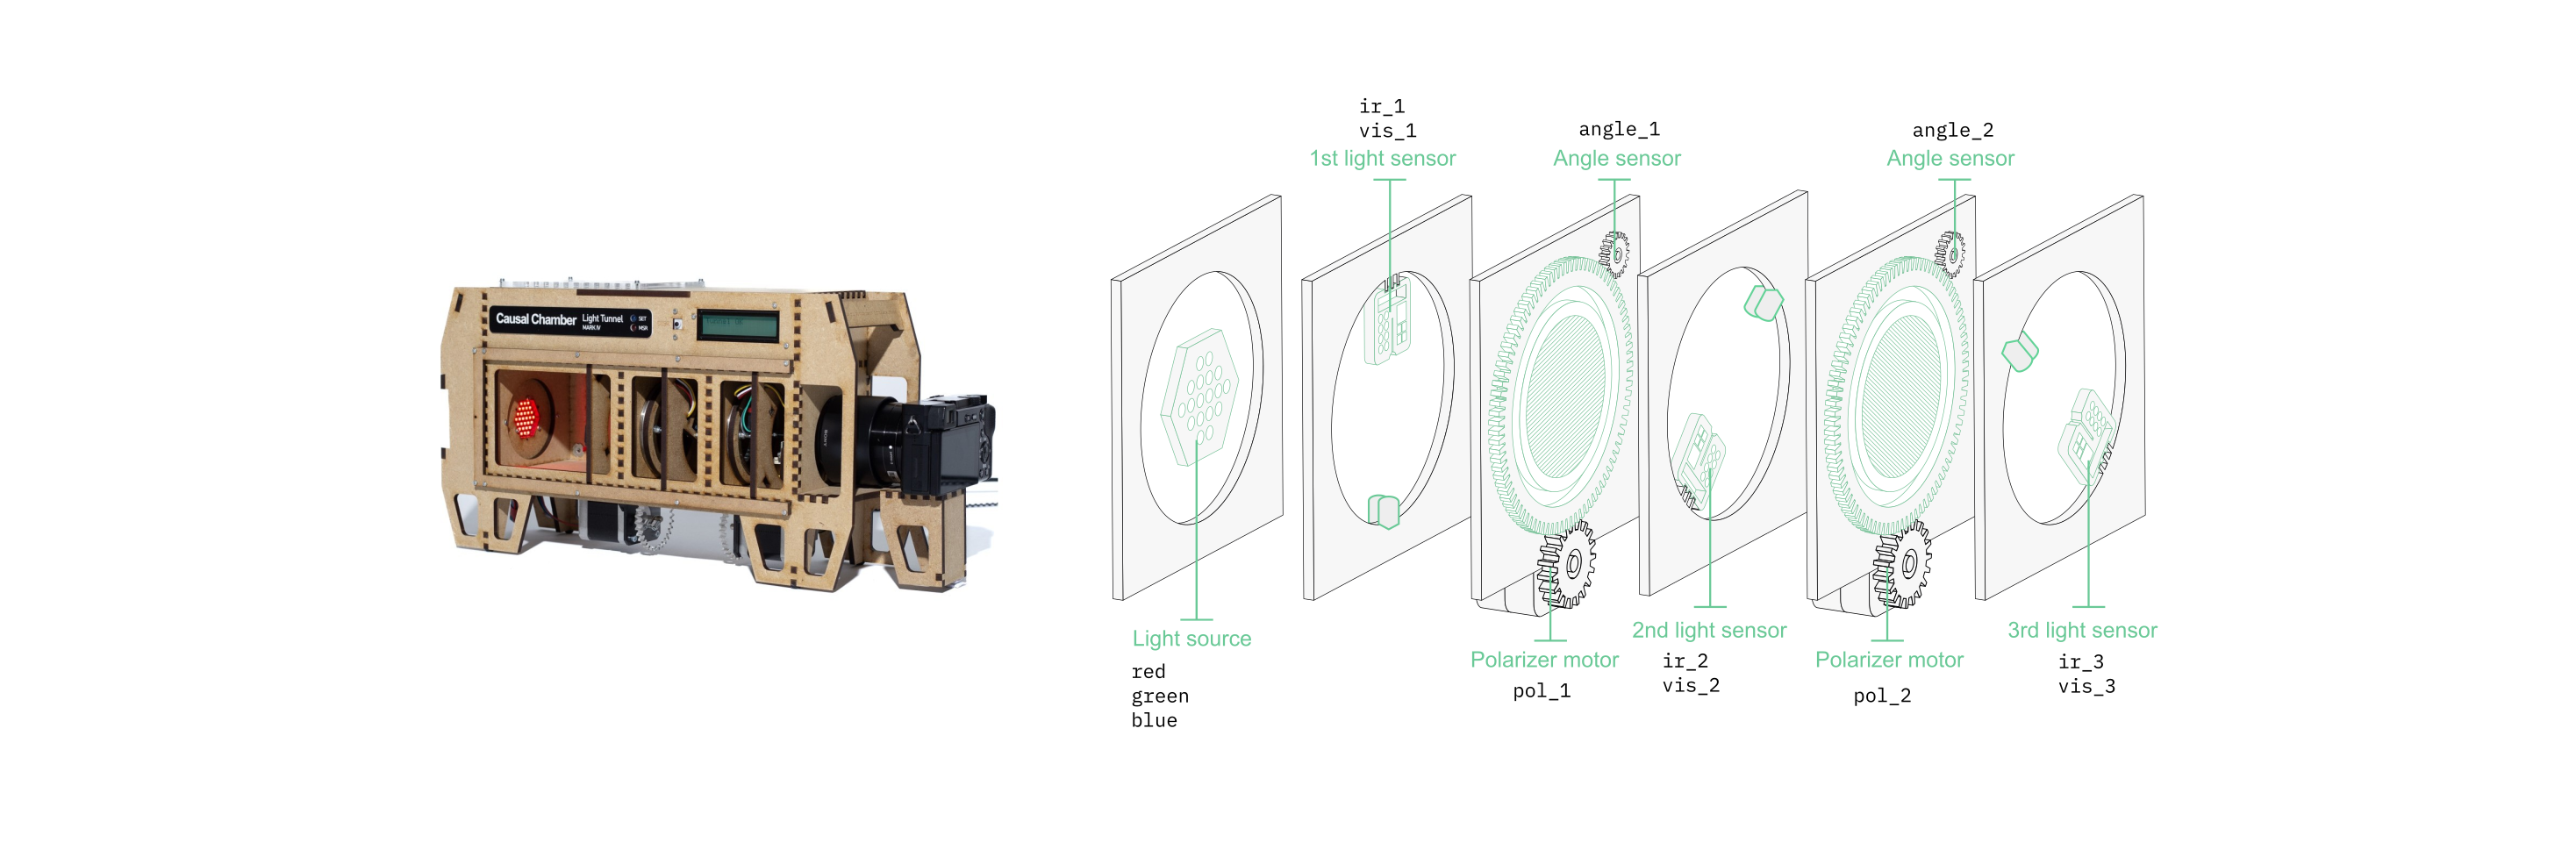

For our treatment, we will set `red=2`. As control, we will set `red=0` while keeping all other variables constant.

<mark style="background-color: #648fff;">Question:</mark> Consider the variables `ir_1, ir_2, vis_2, ir_3` and `angle_1`. Which do you expect to be affected by the change in red brightness?

> Hint: you can find a description of what these variables are [here](https://cchamber-box.s3.eu-central-2.amazonaws.com/config_doc_lt_mk2_standard.pdf)

The variables ir_1, ir_2, vis_2, ir_3 will decrease, since are sensor that depends on the light level. In particular, if we decrease the power of the red light, the infrared and visible light recorded will decrease.

The angle will not be influenced, since it is the angle of the first polarizer, but the change of the power of the light will not modify the angle.

<mark style="background-color: #40E0D0;"> Task </mark> 

Create and submit two experiments:

- For the control, set `red=0` and take `n=50` measurements
- For the treatment, set `red=2` and take `n=50` measurements

Remember that you can use `wait_and_download(...)` (defined above) to wait for completion and download the data.

In [18]:
# TODO: your code goes here

def make_experiment_red(red):
    experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')
    experiment.set('red', red)
    experiment.measure(n=50)
    experiment_id = experiment.submit(tag='re')
    return wait_and_download([experiment_id],'/tmp')[0]

control_df=make_experiment_red(0)
treatment_df=make_experiment_red(2)

Waiting for data from 1 experiments



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.50k/9.50k [00:00<00:00, 2.68MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (1/1) downloaded 8373008b-02b7-466a-b717-4608f9d3e581                     
Waiting for data from 1 experiments



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.49k/9.49k [00:00<00:00, 285kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (1/1) downloaded 9aa70c68-1e4b-468e-b357-1a2d11edf515                     


<mark style="background-color: #40E0D0;"> Task </mark> 

Now, let's visualize the data. First, combine your control and treatment dataframes into one:

```python
combined = pd.concat([<control_df>, <treatment_df>], ignore_index=True)
```

and then you can compare the control and treatment histograms for a variable var by calling

```python
    sns.histplot(combined, x=var, hue='red')
```

Your turn!

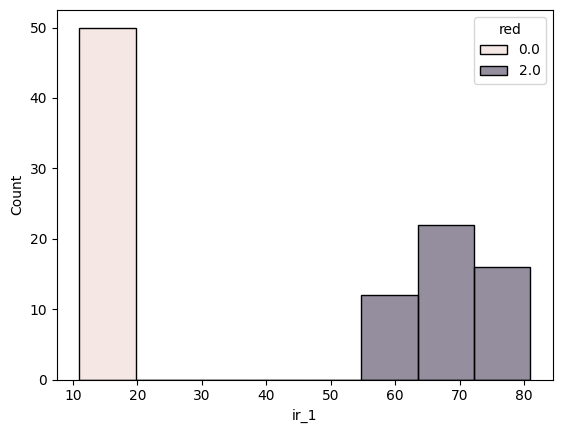

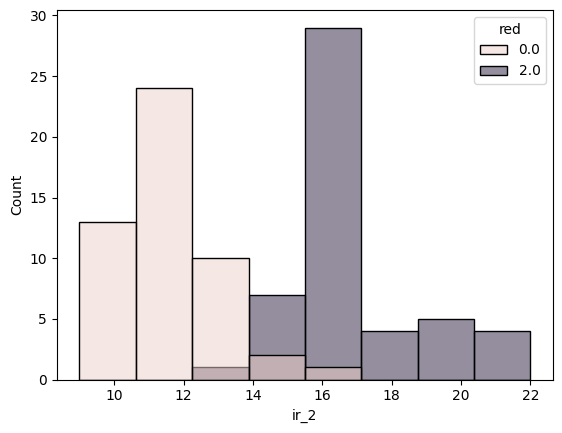

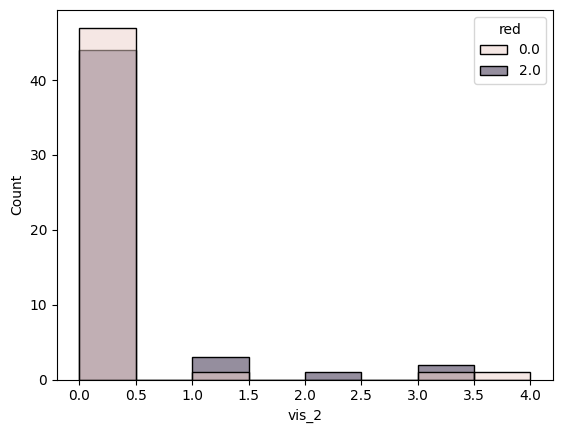

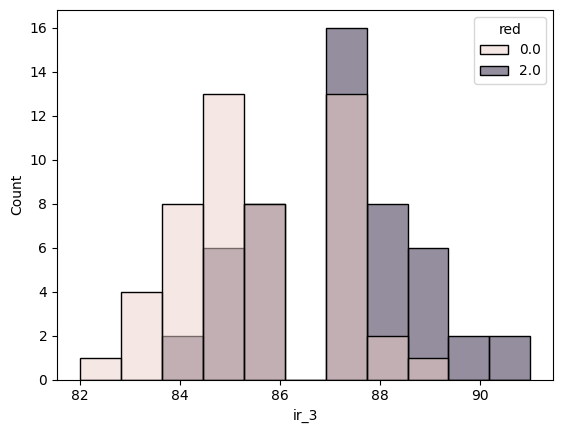

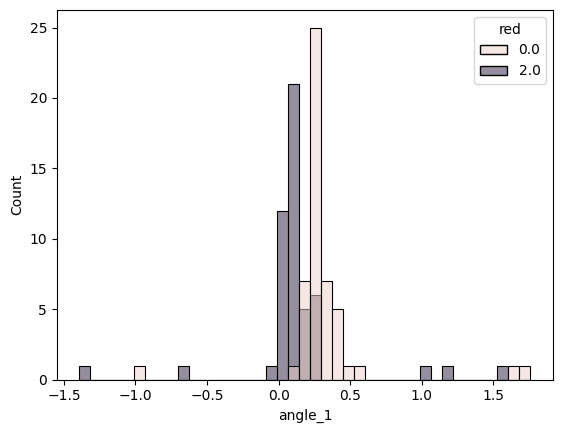

In [26]:
variables = ['ir_1', 'ir_2', 'vis_2', 'ir_3', 'angle_1']

# TODO: your code goes here

combined = pd.concat([control_df,treatment_df], ignore_index=True)
for var in variables:
    sns.histplot(combined, x=var, hue='red')
    plt.show()

<mark style="background-color: #648fff;">Question:</mark> Which variables are affected by the change in `red` values? Do they match your prediction? Why / why not?

The influence dedcrease while increasing the distance. In particular, it is hard to note the difference in the visible light, since in both the kind of experiments it is close to 0. 

Also the angle measurement is affected, against our prediction. This is againts our prediction. I have no idea why this happen.

## Performing a randomized control experiment

We will now repeat our experiment, but we will randomize our treatment and control assignments.

<mark style="background-color: #40E0D0;"> Task </mark> 

Create and submit `100` experiments where:

- Decide at random if this is a control or treatment experiment (hint: you can call `rng.choice([True, False])` to "flip a coin")
- Set `red=10` if treatment or `red=0` if control
- Collect `n=1` measurements

Then, wait for the experiments to finish and store the resulting data in a list called `dataframes`

In [28]:
experiment_ids = []
rng = np.random.default_rng(42)

# TODO: your code goes here
# Hint: you can call rng.choice([True, False]) to "flip a coin"

dataframes = wait_and_download(experiment_ids, download_dir='todo')

Waiting for data from 0 experiment


In [29]:
experiment_ids = []
rng = np.random.default_rng(42)

# TODO: your code goes here
# Hint: you can call rng.choice([True, False]) to "flip a coin"


experiment_ids=[]
for i in range(100):
    experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')

    if rng.choice([True, False]):
        experiment.set('red', 10)
    else:
        experiment.set('red', 0)
        
    experiment.measure(n=1)
    experiment_ids.append(experiment.submit(tag=f'red_random_{i}'))

dataframes = wait_and_download(experiment_ids, download_dir='/tmp')

Waiting for data from 100 experiments



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 3.41MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (1/100) downloaded 0d4748fe-bccd-4089-a313-10e216ab798b                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.55MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (2/100) downloaded 81ac9a93-5b29-4d73-9f67-e87b17cce063                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.78k/1.78k [00:00<00:00, 485kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (3/100) downloaded aafa44c2-37ed-4181-be79-84f7bc486ca5                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 1.46MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (4/100) downloaded c11636a3-f900-4572-b50a-674c2309a1f0                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.09MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (5/100) downloaded 3552d460-114d-4fa6-9d96-a1462c6fc151                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.74MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (6/100) downloaded de848656-a22b-4389-ad43-d6464fe02ced                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.84MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (7/100) downloaded 845e18e1-f061-4a34-b6ce-e30c1cef0657                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 4.94MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (8/100) downloaded 117e11f1-36e8-4417-95af-35b2a7bea75d                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.38MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (9/100) downloaded 5a76bc35-80b7-4a2f-9b9d-da97a2a212a4                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.19MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (10/100) downloaded 3a0738bc-d019-4fe3-b897-a555ac59598e                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 4.90MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (11/100) downloaded 768b46e5-7e3b-4a83-955c-a7ff479ddb98                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 6.00MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (12/100) downloaded 523f2aaa-c776-44a7-9eb4-48eb2f42d6c8                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.82MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (13/100) downloaded 2194efa3-ce1b-432c-979e-bfea5c71e0e0                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.60MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (14/100) downloaded 54447391-29f1-453b-acf3-795b9cee823f                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 4.12MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (15/100) downloaded f10c37c2-247b-45e6-b377-a85c916cd06c                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 2.38MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (16/100) downloaded c6e593ba-3387-4035-be32-21cda6219366                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 2.58MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (17/100) downloaded 5a35e954-71ed-4f17-9a10-3b413e21f6a5                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.57MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (18/100) downloaded cec861ee-7c7c-40ef-9635-ce4c0ade4d06                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 7.73MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (19/100) downloaded 0e730a80-4ce3-42e6-a5e1-8a81564afc29                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 6.43MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (20/100) downloaded aa9f1888-4f9a-4cba-a3e9-dfb171808f1a                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.77MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (21/100) downloaded aaf4e551-5a6a-4329-bee6-99e8b0146a53                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.84MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (22/100) downloaded 0fbcc6b6-149c-4ffd-91d9-eb8c852c8e2d                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 889kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (23/100) downloaded 3865ba99-71b5-4676-80ee-ad49280f303d                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.75MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (24/100) downloaded 749098a7-edef-434a-a48d-14e0fea4118c                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 2.01MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (25/100) downloaded 0b25c9b9-90ff-4e3e-8391-7cf1b20d311c                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 7.52MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (26/100) downloaded 9be28b1c-1b8e-4536-a696-d5b2d0ef1aab                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 3.51MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (27/100) downloaded 2f10d9e5-01bb-4d5a-8d6b-d3f4591429a8                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.18MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (28/100) downloaded bf24eebd-2fa8-4ecb-adfb-75a287f20350                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.66MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (29/100) downloaded 34e9354c-b50a-4166-b54f-05265f6a8317                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.43MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (30/100) downloaded d0780cf5-3a63-416f-b5b5-6970862960fe                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 5.27MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (31/100) downloaded f5ad24f5-6ed8-40bf-8dba-c13f0857aa27                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 6.43MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (32/100) downloaded 065cf149-96d4-48c3-8119-94698fe4b3cf                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.15MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (33/100) downloaded d4db78f0-f02a-4792-9ec1-e51566034f4e                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 2.25MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (34/100) downloaded 94713769-4e34-430e-b32f-36af2c0a2f07                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.22MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (35/100) downloaded 5791873b-83ba-479a-b9bd-19381e9d8383                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.04MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (36/100) downloaded 39c38446-be7f-43e9-92a3-e095fc44040c                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 642kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (37/100) downloaded 5d3b7511-4eab-4578-979e-9c1f003b7ad8                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 1.02MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (38/100) downloaded 66616236-7020-48fb-8987-0a6f8c2091f2                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.77MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (39/100) downloaded e7da2887-7f41-41fd-803d-5635a4d50a56                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 4.74MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (40/100) downloaded c4674ad8-8e94-442c-b068-fe896305267c                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 770kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (41/100) downloaded 5b8ddc51-65f1-4b2e-9721-e70e436932ab                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 4.71MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (42/100) downloaded 3739a2de-ac15-4fca-9b67-b955178fdda1                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.22MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (43/100) downloaded 02ce85ee-c909-4914-9783-d00dd3919d58                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.78k/1.78k [00:00<00:00, 5.75MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (44/100) downloaded f4795c5e-8fbc-4da6-902f-fe455f843d8d                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.06MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (45/100) downloaded c74d8912-b559-4cf6-a7c2-09bb56f5e0b0                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.24MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (46/100) downloaded f2000e10-7c8a-4334-bb95-4f0fc3fc0294                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.22MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (47/100) downloaded 595b3e28-3cf1-44da-8179-9da031df39e2                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.26MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (48/100) downloaded 9f9fbadc-7ed1-4238-8fbe-8de197b60ef1                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.53MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (49/100) downloaded 67067e6c-80cc-427f-8d80-544f888f01fc                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 3.76MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (50/100) downloaded de78f1b3-29ca-4226-9e7b-a7058313a4dd                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.86MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (51/100) downloaded d3628806-245d-47a5-86b6-3a94c710879b                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 6.27MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (52/100) downloaded 7eda612b-8886-4525-81e9-ba82a48cb402                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 7.37MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (53/100) downloaded ec18602b-257f-4db9-b1df-b682814cb19c                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.71MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (54/100) downloaded 3976a83a-18d0-452b-8536-b0f9cc8533d3                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 4.71MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (55/100) downloaded 30dc25b0-d072-463f-8948-c44c55d82c5e                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.78k/1.78k [00:00<00:00, 944kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (56/100) downloaded 87ea5723-7375-4e8e-ae65-81a382d0680b                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.78k/1.78k [00:00<00:00, 4.89MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (57/100) downloaded 54936a18-c688-40c9-acc8-82ea859262ce                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 3.34MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (58/100) downloaded 7c87c3cc-1e68-4dd2-bfb7-91ae4e01df0e                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 597kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (59/100) downloaded 8ca23f0a-225a-485d-8c27-27f3281f33db                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.78k/1.78k [00:00<00:00, 919kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (60/100) downloaded 1c62c1c2-5410-474c-9765-74240f74c5d8                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.78k/1.78k [00:00<00:00, 1.43MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (61/100) downloaded a607329c-1f17-45ff-b570-6ac11149745a                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.95MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (62/100) downloaded 2101466c-f896-4100-845e-ae5171972aab                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.37MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (63/100) downloaded 81d48045-e405-4c7d-9da0-d586b62fcfa7                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 2.76MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (64/100) downloaded 70d12c69-80a4-46d8-a734-97b8d61f2592                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 1.02MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (65/100) downloaded 4bdb9c7b-dab7-4eac-99e3-feda304fb187                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 4.69MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (66/100) downloaded b005ca28-2a2c-4029-8464-befbc5c7daf6                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.87MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (67/100) downloaded 291b1133-e90e-4f19-bc4b-535006652621                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 6.01MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (68/100) downloaded 3171556d-3336-42d5-ba21-bd8dd89e5d3e                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 1.49MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (69/100) downloaded 279a40db-1a4c-41d7-be3b-0f17e76f4f58                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 3.86MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (70/100) downloaded d59469dc-0b92-405e-a021-12b292c4790d                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.82MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (71/100) downloaded 4ec9e9da-9506-4141-b3f5-157bc1199f53                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 1.09MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (72/100) downloaded 87f1f4c5-589d-40df-a60d-a5756ba7c0cc                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 2.61MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (73/100) downloaded b28ee4e7-4e9e-41b3-b1cc-7e8be5343cab                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.24MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (74/100) downloaded beb91757-d3af-4c5d-9695-32b01b6eaf7c                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.88MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (75/100) downloaded 669ee229-0c23-42c8-89a3-d4565cd1d0a5                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.81k/1.81k [00:00<00:00, 5.32MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (76/100) downloaded 63bc223d-80eb-4cc9-93dd-f3c80077ed6c                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.62MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (77/100) downloaded 2431489e-aece-4c9f-a17b-c408c8f1a183                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.45MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (78/100) downloaded 370a9676-7d29-4d4a-9611-3904535a4863                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 322kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (79/100) downloaded ea30bdec-411d-493e-9af1-9ea5050c37e7                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 4.38MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (80/100) downloaded 9c78d2bb-532a-47fd-a049-0b22eb8d48ae                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.25MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (81/100) downloaded 44f0cc31-cadb-4101-8cd7-694acab07028                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.76MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (82/100) downloaded 4663ebd6-dcfb-4afd-a1e2-541b15f7fa8a                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.59MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (83/100) downloaded e9fdac41-3491-45bf-97ed-5f0a21731881                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 1.07MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (84/100) downloaded af698df2-654d-4917-9b5a-e02ebb45bb0b                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.39MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (85/100) downloaded f4933bb8-3b75-43ec-b1a4-f0be2739681c                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.50MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (86/100) downloaded 7a575d0c-67ad-48c2-bd53-508458e926b7                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.60MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (87/100) downloaded a050c096-afcb-4c5c-b25f-fbabbe7269ca                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.51MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (88/100) downloaded 6cd67591-52a9-4d0f-ba15-4acf29195b72                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.06MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (89/100) downloaded b24db665-54a2-4f71-9d70-a48609c9759a                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 2.14MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (90/100) downloaded ba580e50-516f-41d7-ae53-ca43f1e7c4cf                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 3.98MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (91/100) downloaded 884af605-cb32-4891-a3d5-70db193a4957                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.78k/1.78k [00:00<00:00, 4.74MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (92/100) downloaded 7aa3fcab-a7ab-4477-ba09-aac8a092febc                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 3.27MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (93/100) downloaded 9166ff6a-7925-428b-bdb3-44fbc43e97bc                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 4.81MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (94/100) downloaded a21471c7-8360-40fe-a184-36fbb253e78c                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.79MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (95/100) downloaded 160f13cd-5a5d-4fa0-a73e-d87afd0d443f                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80k/1.80k [00:00<00:00, 5.70MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (96/100) downloaded 067b960a-b7ed-4309-be3b-d2bc6ffd8a3b                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.61MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (97/100) downloaded 8d8316bd-4ef2-4fe2-a08b-b1a8f0f09f67                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 5.24MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (98/100) downloaded b474b470-f8de-43f9-9324-7cf440666914                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 6.36MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (99/100) downloaded ad4de1f9-dc1f-45b7-bda0-29aa0bcc886a                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.79k/1.79k [00:00<00:00, 8.31MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.
  (100/100) downloaded 63cb994d-b6e8-4b7f-9302-1be6df8bc67a                     


<br>

<mark style="background-color: #40E0D0;"> Task </mark>

Now lets visualize the results. Again, you can combine all the data by calling

In [30]:
data = pd.concat(dataframes, ignore_index=True)

and then plot the marginal distributions by calling

```python
sns.histplot(data, x=<variable_name>, hue='red')
```

Plot the new data and compare the distributions of treatment and effect.

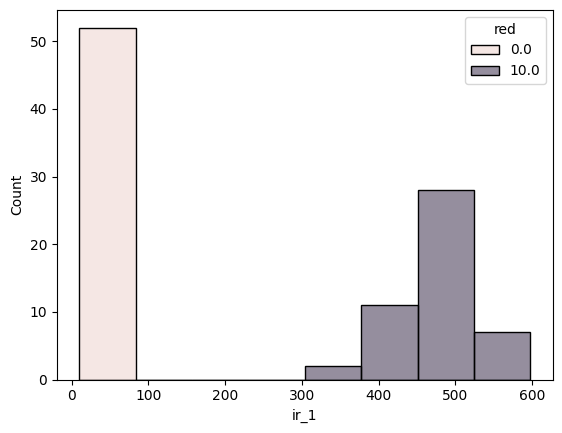

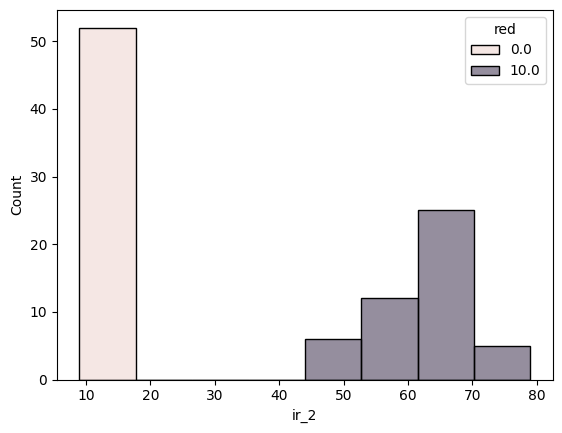

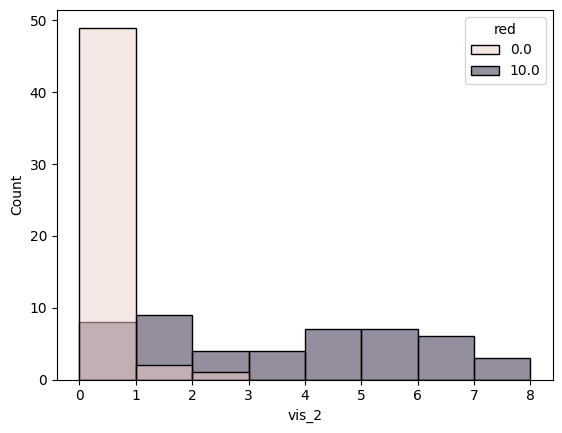

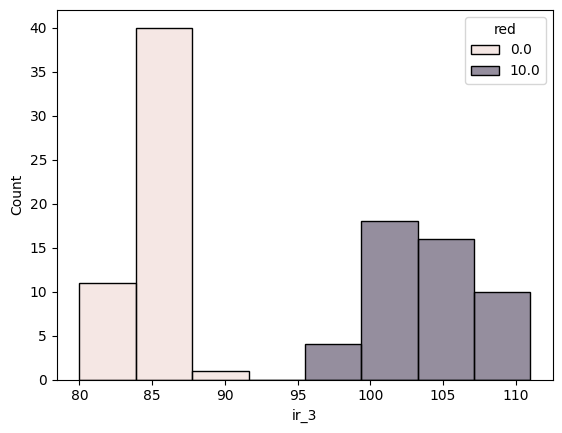

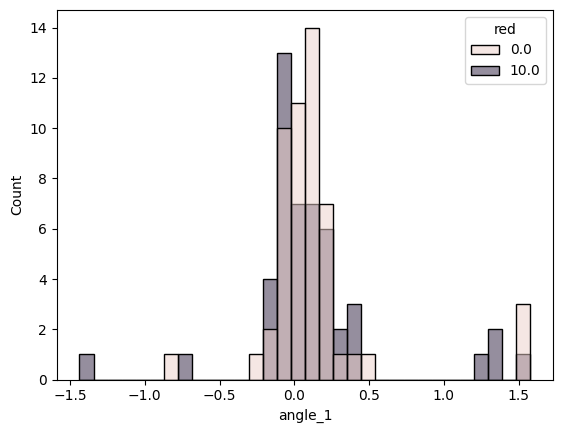

In [32]:
# TODO: your code goes here

for var in variables:
    sns.histplot(data, x=var, hue='red')
    plt.show()


<mark style="background-color: #648fff;">Question:</mark> Which variables are affected by the change in `red` values? What has changed with respect to the non-randomized experiment?

The variables ir_1, ir_2, ir_3 and vis_2 are now evidently affected by the change of the red.
Instead, in this case, the varible angle_1 is not affected by the change in the red variable.

In this case it is more evident that the change in red causes a change in the observation; this is more evident also because we select the value red=10, so also the sensor vis_2 can get more data.

The variable angle is not affected anymore by the measuring. The probable cause for the correlation seen in the previous experiment might be caused bt the ored of the selection of the samples. In particular, we can suppose there has been a small movement during the experiment or it was usead another chamber; in this case the experiment is affected not only by the change in the variable red but also in the order.

## Two-sample testing

Above, you visually evaluated the results to see if there was a difference between treatment and effect. But how can we do this in a quantifiable way? If our measurements contain noise, how can we make sure that what we observed was not simply chance?

Enter: the two-sample test, one of statistics oldest problems (and the one we can solve best).

### The student t-test

We will begin by looking at perhaps one of the oldest (and still widely used) two-sample tests: The student [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)

In [9]:
from scipy.stats import ttest_ind

Let's try the t-test on the data from our randomized experiment above. We will compare the treatment vs. control distributions of each variable.

<mark style="background-color: #648fff;">Question:</mark> Before you start, what do you expect the p-values to look like for each variable? Which do you expect to be higher / lower? Explain your reasoning.

For the variables ir_1, ir_2 and ir_3the p-value will be small, likly close to 0. This come from the fact that in the data we can clary see a dependency, so it is unlikly that this dependency is not caused by the change on the variable red. This value will be be also increasing, in particular starting from ir_1 to ir_3.

Fot the variable vis_2 probably this value will be bigger since in the data we cannot see this evident correlation.


For the variable angle_1, it should be close to 0 too, because we didn't take the data in a real random uniform way, but it was biased by the order, that generated a correlation.


<mark style="background-color: #40E0D0;"> Task </mark> 

Compute and print the p-value resulting from comparing the treatment & control distributions for each variable. To compute the p-value, you can call

```python
ttest_ind(<control_sample>, <treatment_sample>).pvalue
```

In [37]:
# TODO: your code goes here

for var in variables:
    pval=ttest_ind(control_df[var],treatment_df[var]).pvalue
    print(var, pval)

ir_1 7.059676929307317e-79
ir_2 3.259338118201453e-29
vis_2 0.6668201123078606
ir_3 8.94570011707496e-07
angle_1 0.02135145296275568


<mark style="background-color: #648fff;">Question:</mark> Did the results match your expectations?

Yes. In particular, for ir_1, ir_2, ir_3 the p-value is really small (>10^-6) and it increase following the distance.

For the variable vis_2, it it 0.66, so it is unlikly the correlation. This is caused from the limited accurancy in the measurement of the light, that is too close to 0 to get really measured.

The p-value for angle_1 is 0.02, so it is close to 0, but not as close as the variables for ir.

<mark style="background-color: #648fff;">Question:</mark> In your own words, explain what the null hypothesis of the test is in this case, and what the p-value represents.

The null hypothesis in this case is that the variables red and the measured one are indipendent.. From this definition, the p-value is the probability that we observe this data (so with a correlation) assuming the null hypothesis (the variable are not correlated). Then if p-value is small, it mean it is unlikly to measure this data when there is indipendency in the variables.

<mark style="background-color: #648fff;">Question:</mark> Say you want to reject the null-hypothesis at level $\alpha = 0.05$. For which variables do you find a significant effect?

In this case we would reject the null hupothesis for all the variables except the variable vis_2.

### Evaluating level and power

We will now evaluate the level and power of the t-test.

<mark style="background-color: #648fff;">Question:</mark> Can you explain, in your own words, the difference between a type-I error and a type-II error?

The type-I error are errors of the kind that reject the null hypotesis even if it is true.

The type-II errors instead accept the null hypoteis when it is false.

The difference is that in the first case, we reject the null hypotesis and we affirm we have a valid base to afferm something new, like a dependency or a relation in the data, but this situation is just cused by a unusual situation, that might happen. In the second case instead, we say that the null hypotesis is true, so what we are testing for is false, even if it true. In this case it can be cause by an unfortunate situation or the limited number of observation, that aren't enouth to prove that the alternative hypotesis is true.

<mark style="background-color: #648fff;">Question:</mark> Based on your answer, what is the difference between level and power?

The level is the probability below that we reject the null hypotesis; in this case, we have a probability of type-I error equal to the level: if the null hypotesis is true, then the p-value is a uniform variable, so it is possible with probability equal or smaller to the level to make type-I errors.

The power is related in the same way, but to the type-II error: in particular, we fix this value such that if have a bigger value than this one, we are sure that we make type-II errore with probability at least equal to the power.

<mark style="background-color: #40E0D0;"> Task </mark> 

Now, we will evaluate the level and power of the t-test on a hundred repetitions of our experiment.

To save time, we will do the randomization at the _observation_ level, instead of at the experiment level. In particular, create and submit 100 experiments where,

For each experiment:

1. flip a coin (i.e., `rng.choice([True, False])`) and set `red=0` or `red=2` depending on the result
2. collect one measurement
3. repeat steps 1 and 2 ten times, for a total of `100` measurements
4. submit the experiment

You can store the resulting experiment ids in a list called `experiment_ids`. Download the results using `wait_and_download(...)` and store them into a list called `dataframes`.

We suggest you print the experiment ids and store them somehwere (e.g., in a text cell of this notebook) so you don't have to resubmit the experiments if you close the notebook.

In [45]:
experiment_ids = []
rng = np.random.default_rng(42)

for k in range(100): # Outer loop for 100 experiments
    experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')
    for i in range(100): # Inner measurement loop
        if rng.choice([True, False]):
            experiment.set('red', 2)
        else:
            experiment.set('red', 0)
        experiment.measure(n=1)
    experiment_ids.append(experiment.submit(tag=f'red_random_100_{k}'))
        
print(repr(experiment_ids)) # Print experiment ids so you can access them at any time

['56e2f87f-8049-49f5-9334-ac73961f055f', '168eb766-ad7f-4373-b0bb-6ddeaffa37b7', '9bfc4cae-dcca-4aab-b88e-b41f2526e06b', 'db64a5b4-6642-4668-be7d-d73258c797ea', 'c3a3cd84-a566-4e32-88a1-0899b125fe54', '4162724e-86f8-4273-b54e-d90c5d884bf0', '4ffbf13c-35d9-4df1-9ca5-2c736cdddb94', '2fa42842-2eec-4164-8689-9095469b7cdb', 'ba0e8f07-c55b-4b17-9ba4-27b2ab2a6040', '87e6e0b2-9301-403f-9226-145352d61ed1', 'af961678-d54c-4f2f-9bf0-d857e1a8b5c9', 'c38b6e51-b8ca-441c-afe6-79f7bf6dbd42', 'a7e013c1-c4b5-4662-9b8e-8157eebfde54', '99d0a6c6-5234-44c1-8d8d-83a17e33b6d2', 'c9ce27d7-6c33-4000-97f4-68bc5e28ad25', 'd3610ebf-2b5c-4ed5-a8dd-dfb8ea82f145', '4ab240ae-3270-497f-8c1f-a24cb57347b2', '659f336a-8d5e-44a7-8a48-67658804de5b', '39331571-59bb-4c7a-ad3d-c5ebc440cff2', 'bd02a875-9fa2-4b4e-a243-08abe6fa9be9', 'a61915c8-f63e-4b78-82e0-a3993e96dc8a', 'c31f4c8c-04dc-4e2a-8273-da952e284f46', 'fee24de1-4bd7-41cd-b644-0b6e8d722623', 'f41f5a28-a3e9-4c2c-ae86-8068767b7481', 'f0d4f302-9e16-499c-af61-4f5a54c45e18',

In [6]:
experiment_ids=['56e2f87f-8049-49f5-9334-ac73961f055f', '168eb766-ad7f-4373-b0bb-6ddeaffa37b7', '9bfc4cae-dcca-4aab-b88e-b41f2526e06b', 'db64a5b4-6642-4668-be7d-d73258c797ea', 'c3a3cd84-a566-4e32-88a1-0899b125fe54', '4162724e-86f8-4273-b54e-d90c5d884bf0', '4ffbf13c-35d9-4df1-9ca5-2c736cdddb94', '2fa42842-2eec-4164-8689-9095469b7cdb', 'ba0e8f07-c55b-4b17-9ba4-27b2ab2a6040', '87e6e0b2-9301-403f-9226-145352d61ed1', 'af961678-d54c-4f2f-9bf0-d857e1a8b5c9', 'c38b6e51-b8ca-441c-afe6-79f7bf6dbd42', 'a7e013c1-c4b5-4662-9b8e-8157eebfde54', '99d0a6c6-5234-44c1-8d8d-83a17e33b6d2', 'c9ce27d7-6c33-4000-97f4-68bc5e28ad25', 'd3610ebf-2b5c-4ed5-a8dd-dfb8ea82f145', '4ab240ae-3270-497f-8c1f-a24cb57347b2', '659f336a-8d5e-44a7-8a48-67658804de5b', '39331571-59bb-4c7a-ad3d-c5ebc440cff2', 'bd02a875-9fa2-4b4e-a243-08abe6fa9be9', 'a61915c8-f63e-4b78-82e0-a3993e96dc8a', 'c31f4c8c-04dc-4e2a-8273-da952e284f46', 'fee24de1-4bd7-41cd-b644-0b6e8d722623', 'f41f5a28-a3e9-4c2c-ae86-8068767b7481', 'f0d4f302-9e16-499c-af61-4f5a54c45e18', '810164a4-f879-4c08-9f1e-08a15fe3607e', '88014645-458d-4d44-bdd5-f4547bd0f8bd', '3bbfa126-c371-405b-a402-02851cd344b5', '68dc5f4d-6417-466d-940f-92596a63500a', '782e6e76-b40f-4c5a-8d02-ba9c456bf617', '5533965e-3e56-4dbb-addd-99c9d607e9d9', '682a330b-6616-4155-a547-f834ce570d43', '456a242e-3e8c-4b56-860e-79f1c26fdc98', '0e041f10-39db-42b9-96d8-6e1766cc7a7c', 'b851c011-390d-4a31-9308-8e9fef28ac45', 'a7ee5d92-5f6b-4e3e-baca-40b8762942b9', '2adb68cc-d56d-4b4c-a650-8039d0ec10c7', 'e046884c-79b5-416c-bee6-cf883d9e62c6', '2ed15519-3589-4f4f-990c-594057cb34f6', 'f7379624-7201-49ba-9d06-b14247053d60', '7552a20c-6b8d-4076-9c46-46d06191329e', 'e3c2c64d-452e-4a08-ad34-9a5c3160d56a', 'd7169145-400f-45d0-bad5-91928d82b64e', '217122a7-a4b5-4ced-acfd-3bd2c5f87093', 'ef45e711-839a-4721-bcac-e77b9b160994', '5bfb60fc-1c55-4f05-b53f-b9d402ed717b', '2234f12d-b7fa-434a-9ca1-dc9458f0a5b8', '78aefc78-42bd-4e3c-ac8e-66b01c270a2f', 'c45c61c9-8c65-436a-8cd6-b3eb372e1066', 'c0aac1ce-6a02-4eb6-8ebb-8a118395d283', 'f13b40ba-ff4b-40fb-8ec3-891e02b005c9', '99916bc4-3117-49bb-bec6-f482c8584fd0', '5752fdb2-c55a-41af-ba78-840786c5329f', 'bc72fa39-98ef-47f5-b178-f3aa586e97a2', 'b3fe10c6-1eff-4eb6-b395-b6b319719217', '18efc60e-d0c3-4cad-bdce-c542e054c2b9', 'cdab0328-f396-4da9-8b60-92a7ad608721', '11142d02-2f4f-4a3c-9157-26176948e585', '2f0be088-9434-40ec-b860-e86f51e5b0ca', '2c164c25-0cf6-40b0-bd88-32412b3486b4', '230b97a0-a313-4181-ad45-a8baee90e5e0', '5b2b7f4d-4d22-44dd-8f84-bddcbb5a08cc', 'd9743482-465d-4ca0-aa23-1295102935c1', 'b9b08fac-7812-45f4-bafb-dc0fce5f471b', '7865fea9-56e9-4a5f-95f9-bc6e3b25d4dc', 'fc064d01-5266-4625-bfc8-2291051c2ced', '4e48e9a6-8ba5-42c8-b29f-a1982deb9ad1', 'd3d826eb-e3bd-4561-9389-0ee49338ad5a', 'e2eaad5c-0c3a-45b5-b842-d6627b3cc869', '144b01f1-3a1f-4c3d-9781-5f0c48f1ae20', '9c10a0da-aaad-4973-988a-5f71bfc2e22f', '4466d5c0-ac34-42ea-b560-f731655fab67', '1c081d53-2412-4566-abbc-49cc9791d295', '514b9072-b62f-4216-a00d-d981c7207a16', 'e6955f75-6a54-4a0d-8cca-b4f112f15fa3', '8f2c6856-a5b7-4587-aa9c-562f2fb28b5a', '258cc6aa-df36-4d53-bc8c-292ac66e90a5', '9ab1d50b-9727-4ce9-a9c1-08a805eda76f', '3f4e6a03-a06b-4aaa-99f2-58cd6fbf4051', '72b9f043-6e03-4623-a798-93869aa5a46a', 'e374fce1-d93e-4d3b-a188-3bc7c0a31c38', 'f14571b7-09ea-413d-bb5f-8af6b1de11d8', 'c8ad31e6-5485-4ae4-bc2b-1c1bb44db741', '15f4aa04-d475-4373-9c10-18268aba6aed', 'd0cd055c-51a0-4151-9658-1248b09c4ed9', 'cb58b684-4dd8-4b92-8fd7-119de8e4e50d', '91028a5d-da5a-4c85-aa71-f5bef536b54c', '160a5bb4-d81a-4d21-a0d3-355e07b1f8c0', '22fa856f-b706-4148-8da7-1de4ed33f619', '9726e384-e2ab-4c31-b68f-aae79297319c', 'bd442daa-d3eb-4b6d-a11d-33d8463d1d9e', '2889b651-db3f-4c6c-b8a6-42d2e75edc0b', '6cc61e4c-c378-4097-8f1e-f290e14baad6', '7e623713-9e42-4087-ab89-7f0a9713f5be', '88e16163-bc34-4a4a-b0f7-eb633971bf88', 'fce8ea1c-606e-4db8-aacb-9b6798cfb855', '75351dd8-21d0-4247-8c33-ebe5c8c9b38e', '48aae304-8a44-4b22-9a34-1b17ca920de4', '4dfa06bb-cad0-483a-9f04-3ba5507d7bd7', 'b2c76fd8-88ab-4b6f-9395-030ef537583b']


In [7]:
dataframes = wait_and_download(experiment_ids, download_dir='/home/matteo/Desktop/Uni/ML-theory-practic')

Waiting for data from 100 experiments



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 2.32MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (1/100) downloaded 56e2f87f-8049-49f5-9334-ac73961f055f                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 407kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (2/100) downloaded 168eb766-ad7f-4373-b0bb-6ddeaffa37b7                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 1.37MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (3/100) downloaded 9bfc4cae-dcca-4aab-b88e-b41f2526e06b                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 257kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (4/100) downloaded db64a5b4-6642-4668-be7d-d73258c797ea                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 467kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (5/100) downloaded c3a3cd84-a566-4e32-88a1-0899b125fe54                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.53MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (6/100) downloaded 4162724e-86f8-4273-b54e-d90c5d884bf0                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.67MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (7/100) downloaded 4ffbf13c-35d9-4df1-9ca5-2c736cdddb94                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 354kiB/s]

  Verifying checksum...

 done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (8/100) downloaded 2fa42842-2eec-4164-8689-9095469b7cdb                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.49MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (9/100) downloaded ba0e8f07-c55b-4b17-9ba4-27b2ab2a6040                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 324kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (10/100) downloaded 87e6e0b2-9301-403f-9226-145352d61ed1                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.78MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (11/100) downloaded af961678-d54c-4f2f-9bf0-d857e1a8b5c9                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 431kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.


  (12/100) downloaded c38b6e51-b8ca-441c-afe6-79f7bf6dbd42                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.76MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (13/100) downloaded a7e013c1-c4b5-4662-9b8e-8157eebfde54                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.56MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (14/100) downloaded 99d0a6c6-5234-44c1-8d8d-83a17e33b6d2                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.6k/16.6k [00:00<00:00, 55.0kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (15/100) downloaded c9ce27d7-6c33-4000-97f4-68bc5e28ad25                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.60MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (16/100) downloaded d3610ebf-2b5c-4ed5-a8dd-dfb8ea82f145                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.6k/16.6k [00:00<00:00, 2.15MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (17/100) downloaded 4ab240ae-3270-497f-8c1f-a24cb57347b2                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.56MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (18/100) downloaded 659f336a-8d5e-44a7-8a48-67658804de5b                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.77MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (19/100) downloaded 39331571-59bb-4c7a-ad3d-c5ebc440cff2                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 393kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (20/100) downloaded bd02a875-9fa2-4b4e-a243-08abe6fa9be9                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 56.3kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (21/100) downloaded a61915c8-f63e-4b78-82e0-a3993e96dc8a                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.6k/16.6k [00:00<00:00, 522kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (22/100) downloaded c31f4c8c-04dc-4e2a-8273-da952e284f46                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 2.13MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (23/100) downloaded fee24de1-4bd7-41cd-b644-0b6e8d722623                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 856kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (24/100) downloaded f41f5a28-a3e9-4c2c-ae86-8068767b7481                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 200kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (25/100) downloaded f0d4f302-9e16-499c-af61-4f5a54c45e18                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.6k/16.6k [00:00<00:00, 919kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (26/100) downloaded 810164a4-f879-4c08-9f1e-08a15fe3607e                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.34MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (27/100) downloaded 88014645-458d-4d44-bdd5-f4547bd0f8bd                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 859kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (28/100) downloaded 3bbfa126-c371-405b-a402-02851cd344b5                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 248kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (29/100) downloaded 68dc5f4d-6417-466d-940f-92596a63500a                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.10MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (30/100) downloaded 782e6e76-b40f-4c5a-8d02-ba9c456bf617                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 335kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (31/100) downloaded 5533965e-3e56-4dbb-addd-99c9d607e9d9                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 1.51MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (32/100) downloaded 682a330b-6616-4155-a547-f834ce570d43                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 404kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (33/100) downloaded 456a242e-3e8c-4b56-860e-79f1c26fdc98                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 17.7MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (34/100) downloaded 0e041f10-39db-42b9-96d8-6e1766cc7a7c                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.15MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (35/100) downloaded b851c011-390d-4a31-9308-8e9fef28ac45                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 424kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (36/100) downloaded a7ee5d92-5f6b-4e3e-baca-40b8762942b9                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 51.9kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (37/100) downloaded 2adb68cc-d56d-4b4c-a650-8039d0ec10c7                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 750kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (38/100) downloaded e046884c-79b5-416c-bee6-cf883d9e62c6                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 987kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (39/100) downloaded 2ed15519-3589-4f4f-990c-594057cb34f6                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 1.42MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (40/100) downloaded f7379624-7201-49ba-9d06-b14247053d60                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.6k/16.6k [00:00<00:00, 2.23MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (41/100) downloaded 7552a20c-6b8d-4076-9c46-46d06191329e                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 345kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (42/100) downloaded e3c2c64d-452e-4a08-ad34-9a5c3160d56a                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 848kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (43/100) downloaded d7169145-400f-45d0-bad5-91928d82b64e                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.33MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (44/100) downloaded 217122a7-a4b5-4ced-acfd-3bd2c5f87093                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.19MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (45/100) downloaded ef45e711-839a-4721-bcac-e77b9b160994                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 942kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (46/100) downloaded 5bfb60fc-1c55-4f05-b53f-b9d402ed717b                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.37MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (47/100) downloaded 2234f12d-b7fa-434a-9ca1-dc9458f0a5b8                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.6k/16.6k [00:00<00:00, 1.87MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (48/100) downloaded 78aefc78-42bd-4e3c-ac8e-66b01c270a2f                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 163kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (49/100) downloaded c45c61c9-8c65-436a-8cd6-b3eb372e1066                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.82MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (50/100) downloaded c0aac1ce-6a02-4eb6-8ebb-8a118395d283                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.43MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (51/100) downloaded f13b40ba-ff4b-40fb-8ec3-891e02b005c9                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.7k/16.7k [00:00<00:00, 254kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (52/100) downloaded 99916bc4-3117-49bb-bec6-f482c8584fd0                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 102kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (53/100) downloaded 5752fdb2-c55a-41af-ba78-840786c5329f                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 258kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (54/100) downloaded bc72fa39-98ef-47f5-b178-f3aa586e97a2                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.69MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (55/100) downloaded b3fe10c6-1eff-4eb6-b395-b6b319719217                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.50MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (56/100) downloaded 18efc60e-d0c3-4cad-bdce-c542e054c2b9                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.68MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (57/100) downloaded cdab0328-f396-4da9-8b60-92a7ad608721                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 507kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (58/100) downloaded 11142d02-2f4f-4a3c-9157-26176948e585                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.7k/16.7k [00:00<00:00, 786kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (59/100) downloaded 2f0be088-9434-40ec-b860-e86f51e5b0ca                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.6k/16.6k [00:00<00:00, 1.62MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (60/100) downloaded 2c164c25-0cf6-40b0-bd88-32412b3486b4                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 178kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (61/100) downloaded 230b97a0-a313-4181-ad45-a8baee90e5e0                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 2.00MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (62/100) downloaded 5b2b7f4d-4d22-44dd-8f84-bddcbb5a08cc                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 2.06MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (63/100) downloaded d9743482-465d-4ca0-aa23-1295102935c1                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.41MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (64/100) downloaded b9b08fac-7812-45f4-bafb-dc0fce5f471b                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 555kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (65/100) downloaded 7865fea9-56e9-4a5f-95f9-bc6e3b25d4dc                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 283kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (66/100) downloaded fc064d01-5266-4625-bfc8-2291051c2ced                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 272kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (67/100) downloaded 4e48e9a6-8ba5-42c8-b29f-a1982deb9ad1                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.79MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (68/100) downloaded d3d826eb-e3bd-4561-9389-0ee49338ad5a                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 2.14MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (69/100) downloaded e2eaad5c-0c3a-45b5-b842-d6627b3cc869                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 1.57MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (70/100) downloaded 144b01f1-3a1f-4c3d-9781-5f0c48f1ae20                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.49MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (71/100) downloaded 9c10a0da-aaad-4973-988a-5f71bfc2e22f                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 412kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (72/100) downloaded 4466d5c0-ac34-42ea-b560-f731655fab67                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 403kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (73/100) downloaded 1c081d53-2412-4566-abbc-49cc9791d295                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 363kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (74/100) downloaded 514b9072-b62f-4216-a00d-d981c7207a16                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 2.67MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (75/100) downloaded e6955f75-6a54-4a0d-8cca-b4f112f15fa3                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 378kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (76/100) downloaded 8f2c6856-a5b7-4587-aa9c-562f2fb28b5a                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.42MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (77/100) downloaded 258cc6aa-df36-4d53-bc8c-292ac66e90a5                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 42.9kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (78/100) downloaded 9ab1d50b-9727-4ce9-a9c1-08a805eda76f                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.62MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (79/100) downloaded 3f4e6a03-a06b-4aaa-99f2-58cd6fbf4051                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 783kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (80/100) downloaded 72b9f043-6e03-4623-a798-93869aa5a46a                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 1.66MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (81/100) downloaded e374fce1-d93e-4d3b-a188-3bc7c0a31c38                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 50.9kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (82/100) downloaded f14571b7-09ea-413d-bb5f-8af6b1de11d8                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 434kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (83/100) downloaded c8ad31e6-5485-4ae4-bc2b-1c1bb44db741                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 1.81MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (84/100) downloaded 15f4aa04-d475-4373-9c10-18268aba6aed                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.64MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (85/100) downloaded d0cd055c-51a0-4151-9658-1248b09c4ed9                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 35.5MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (86/100) downloaded cb58b684-4dd8-4b92-8fd7-119de8e4e50d                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.56MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (87/100) downloaded 91028a5d-da5a-4c85-aa71-f5bef536b54c                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 212kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (88/100) downloaded 160a5bb4-d81a-4d21-a0d3-355e07b1f8c0                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.64MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (89/100) downloaded 22fa856f-b706-4148-8da7-1de4ed33f619                     


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 427kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (90/100) downloaded 9726e384-e2ab-4c31-b68f-aae79297319c                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 214kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (91/100) downloaded bd442daa-d3eb-4b6d-a11d-33d8463d1d9e                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 1.64MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (92/100) downloaded 2889b651-db3f-4c6c-b8a6-42d2e75edc0b                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 426kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (93/100) downloaded 6cc61e4c-c378-4097-8f1e-f290e14baad6                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 1.16MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (94/100) downloaded 7e623713-9e42-4087-ab89-7f0a9713f5be                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 1.49MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (95/100) downloaded 88e16163-bc34-4a4a-b0f7-eb633971bf88                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 53.9kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (96/100) downloaded fce8ea1c-606e-4db8-aacb-9b6798cfb855                     



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.3k/16.3k [00:00<00:00, 430kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (97/100) downloaded 75351dd8-21d0-4247-8c33-ebe5c8c9b38e                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.4k/16.4k [00:00<00:00, 1.75MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (98/100) downloaded 48aae304-8a44-4b22-9a34-1b17ca920de4                     


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.5k/16.5k [00:00<00:00, 1.16MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (99/100) downloaded 4dfa06bb-cad0-483a-9f04-3ba5507d7bd7                     



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16.1k/16.1k [00:00<00:00, 41.4kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic"... done.
  (100/100) downloaded b2c76fd8-88ab-4b6f-9395-030ef537583b                     


<br>

Now we will check how often the null is rejected in the 100 experiments for each of our variables.

<mark style="background-color: #648fff;">Question:</mark> At level $\alpha=0.05$, in what percentage of the tests will the null be rejected (i.e., p-value < $\alpha$) `ir_1`, `ir_2`, `vis_2`, `ir_3` and `angle_1`?

Based on the result of the previous experiment, for the variables ir_1, ir_2, ir_3 the null will be rejected in all the experiments.

For the variable vis_2, the null hypotesys will be rejected in 91% of the experiments.

For the variable angle_1, the null hypotesys will be rejected in around 5% of the experiments.

<mark style="background-color: #40E0D0;"> Task </mark> 

Now compute the p-values for each variable across the 100 experiments and store them in a dictionary (see e.g., `pvals` below). Compute and print the rejection rate for each variable, i.e., the proportion of experiments in which the null is rejected at level $\alpha=0.05$.

Note: you can separate the control and treatment observations in a dataframe `df` by calling

```python
df_control = df[df.red == 0]
df_treatment = df[df.red != 0]
```

And you can compute the p-value by calling

```python
ttest_ind(df_control[variable], df_treatment[variable]).pvalue
```



In [10]:
variables = ['ir_1', 'ir_2', 'vis_2', 'ir_3', 'angle_1']
pvals = {var: [] for var in variables}
level = 0.05

for df in dataframes:
    df_control = df[df.red == 0]
    df_treatment = df[df.red != 0]
    for variable in variables:
        pvals[variable].append(ttest_ind(df_control[variable], df_treatment[variable]).pvalue)



for var in variables:
    rej=0
    for x in pvals[var]:
        if x<level:
            rej+=1
    print(var,rej)

ir_1 100
ir_2 100
vis_2 15
ir_3 100
angle_1 3


<mark style="background-color: #648fff;">Question:</mark> Did you predictions hold?

For the variables ir yes, since it is rejected in all the cases. 

For the variable angle_1 it is 3% against the 5% in the prediction, but this is a small error compared to the real one.

For the variable vis_2 it is not clear, since it is rejected in 15% of the experiment, against the prediction. This result is unexpected since in the first experiment the result was 35%, but the second experiment suggests a correlation in the test case.

<mark style="background-color: #40E0D0;"> Task </mark> 

Plot the distributions of p-values for each variable across the 100 experiments. Use [`sns.histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html).

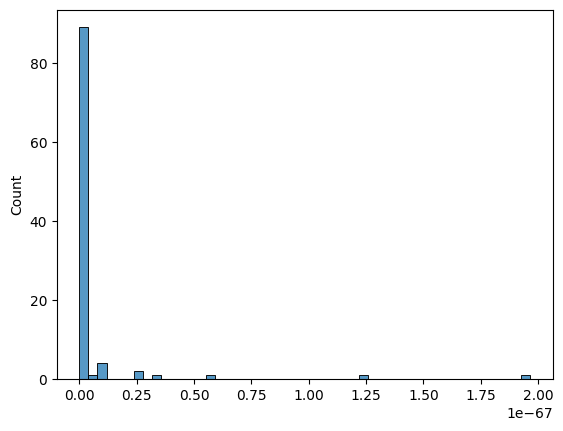

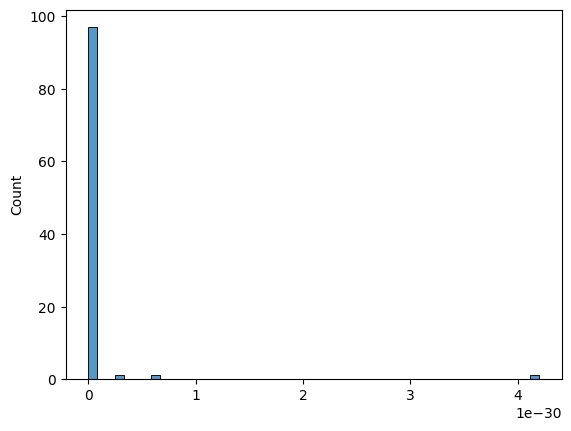

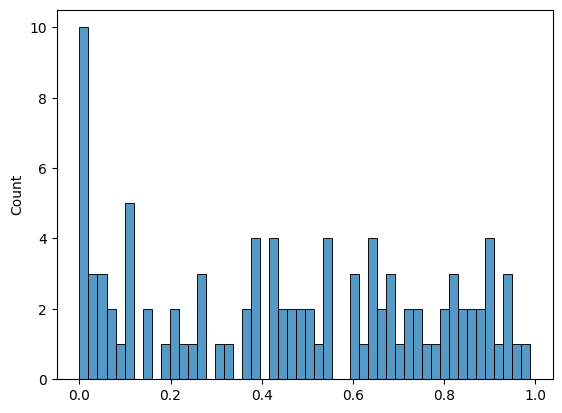

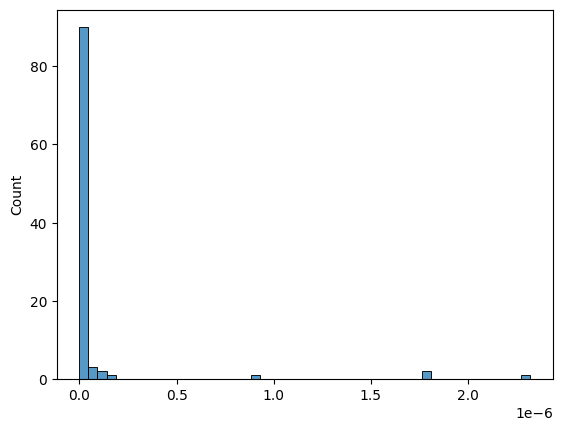

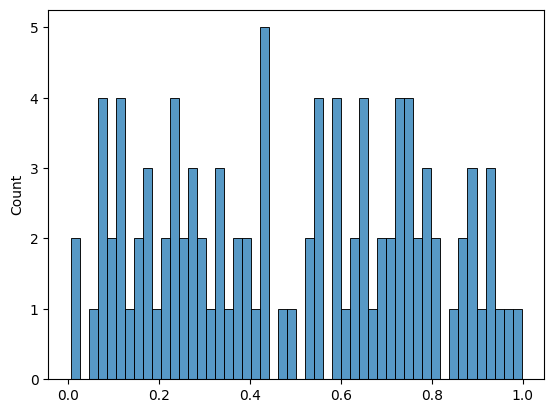

In [35]:
# TODO: your code goes here

for var in variables:
    sns.histplot(np.array(pvals[var]),bins=50)
    plt.show()
    

<mark style="background-color: #648fff;">Question:</mark> Would you say the test is valid at level $\alpha$? Explain your reasoning.

For the variables ir_1,ir_2 and ir_3 yes because it the value are distributed all under 10^-6, and all the values are condensed under the level.

For the variable angle_1 we can see the distribution is almost uniform, as predicted, so it make sense some experiment has a pvalue under the level.

For the variable vis_2 instead the test is not valid, since the distribution doesn't show either a significant proof of the correlation, and it is not a uniform distribution since the values are more dense around smaller value.


<mark style="background-color: #40E0D0;"> Task </mark> 

Using the stored p-values for `angle_1`, compute the rejection rate for different values of $\alpha$ (see variable `levels` below). Then, make a plot of the results, with `alpha` on the x-axis and the rejection rate on the y-axis. Overlay the line $y=x$ on this plot.

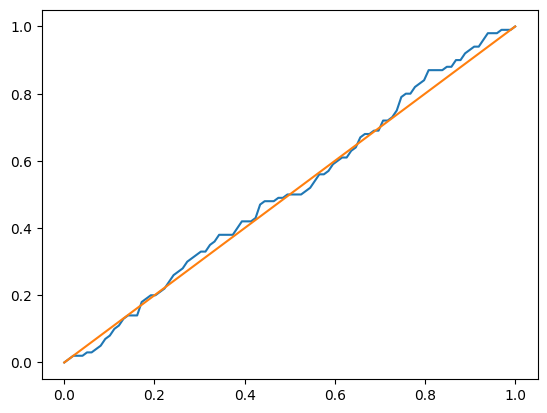

In [34]:
levels = np.linspace(0,1,100)
rejection_rates = []


for alpha in levels:
    rej=0
    for x in pvals['angle_1']:
        if x<alpha:
            rej+=1
    rejection_rates.append(rej/len(pvals['angle_1']))



plt.plot(levels, rejection_rates)
plt.plot(levels,levels)


<mark style="background-color: #648fff;">Question:</mark> Does the test provide the correct level for all values of $\alpha$? Why / why not?

Yes, it matchs almost perfectly the ideal line in the case the null hypotesis is true: in fact, if the null hypotesis is true, then the distribution is uniform. In this case, if we compare the distribution with the values, we can see this is a resulting cumlative ditribution.

<mark style="background-color: #648fff;">Question:</mark> If this were an ideal test, what should the level vs. type-I error curve look like?

In an ideal test, the line should looks similar to this result, but the two line would have been the same. In this case we suffer for the approximation in the limited number of experiment, but if we take n -> $\inf$ the experimenst should show the two lines eqaul.

### Using a non-parametric test

Now, let's repeat our analysis using the non-parametric [Rank-Sum test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

In [36]:
from scipy.stats import ranksums

<mark style="background-color: #40E0D0;"> Task </mark> 

As for the t-test, compute the p-values for each variable across all of the 100 experiments. Print the rejection rates for $\alpha=0.05$ and plot the distributions of p-values as above.

ir_1 100
ir_2 100
vis_2 3
ir_3 100
angle_1 4


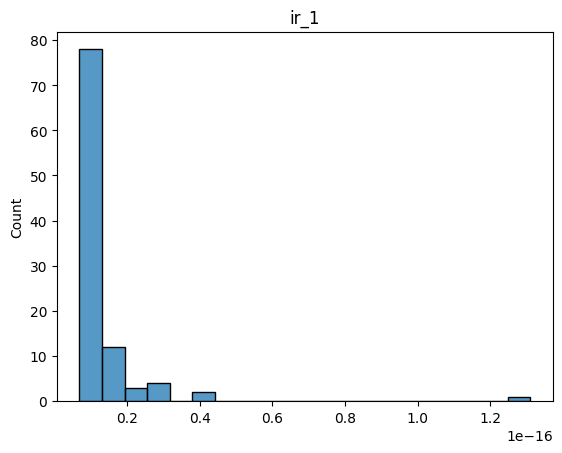

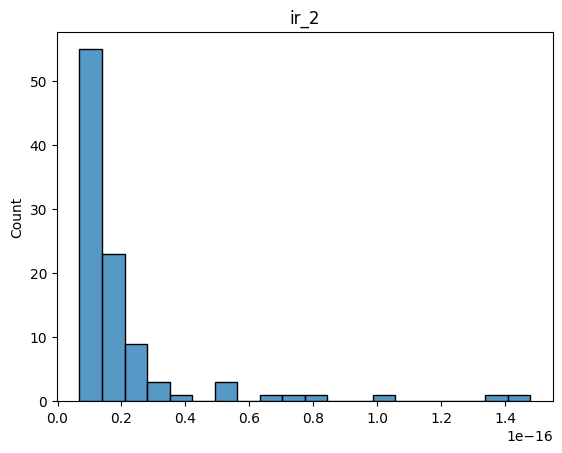

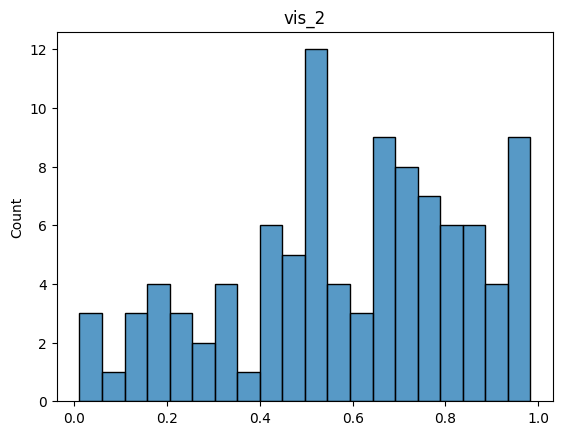

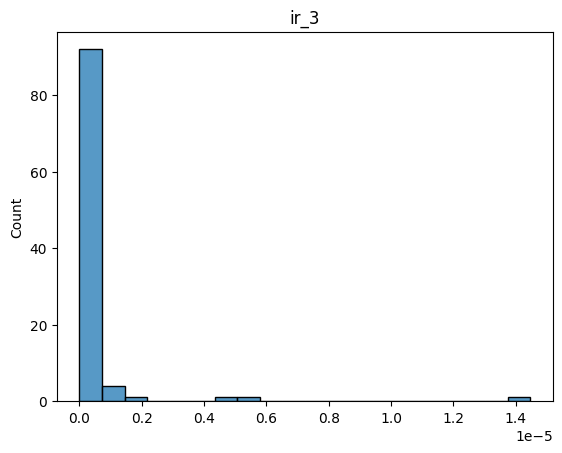

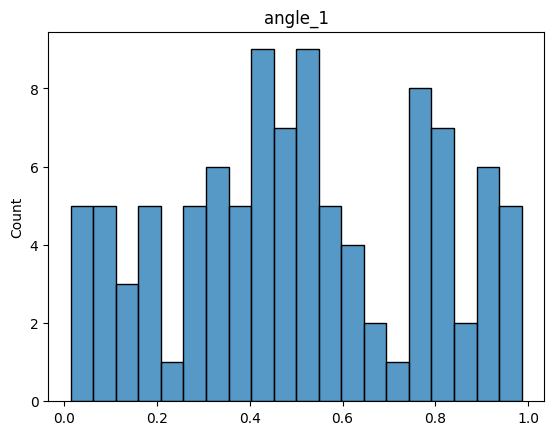

In [40]:
variables = ['ir_1', 'ir_2', 'vis_2', 'ir_3', 'angle_1']
pvals = {var: [] for var in variables}
level = 0.05

# TODO: your code goes here

for df in dataframes:
    df_control = df[df.red == 0]
    df_treatment = df[df.red != 0]
    for variable in variables:
        pvals[variable].append(ranksums(df_control[variable], df_treatment[variable]).pvalue)



for var in variables:
    rej=0
    for x in pvals[var]:
        if x<level:
            rej+=1
    print(var,":",rej,"%")


for var in variables:
    sns.histplot(np.array(pvals[var]),bins=20)
    plt.title(var)
    plt.show()
    

<mark style="background-color: #648fff;">Question:</mark> Would you say the rank-sum test is more or less powerful than the t-test? Explain your reasoning.

In [ ]:
This test looks more general, because it test not only if two distribution have the same average value, but also if the fistribution is the same. 
In particular, it does not require the assumtions the data are distributed are normal with the same variance. 

Following from those conditions, if the two distribution are not normals, then the test cannot be sure to give a correct result.

<mark style="background-color: #648fff;">Question:</mark> Look at the distribution of p-values for `angle_1`? Why does it now follow a uniform distribution?

In [41]:
It looks still like a uniform distribution. 

In this case the difference is that also the p-value for vis_2 follow a uniform distribution; this is caused because the distribution was not normal

SyntaxError: invalid syntax (510263346.py, line 1)

<mark style="background-color: #648fff;">Question:</mark> What will the level vs. type-I error curve look like for `angle_1`? 

In [ ]:
Same as before. This time will be also with the distribution for vis_2

<mark style="background-color: #40E0D0;"> Task </mark> 

Plot the level vs. type-I error curve for `angle_1` and check your answer.

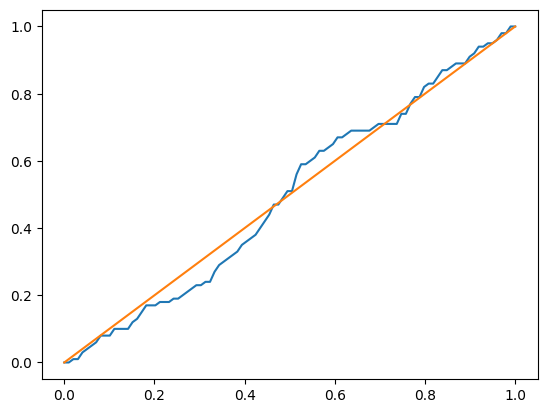

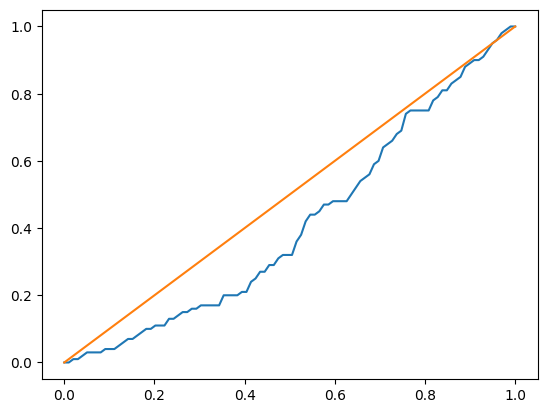

In [46]:
levels = np.linspace(0,1,100)
actual_rates = []


for alpha in levels:
    rej=0
    for x in pvals['angle_1']:
        if x<alpha:
            rej+=1
    actual_rates.append(rej/len(pvals['angle_1']))



plt.plot(levels, actual_rates)
plt.plot(levels,levels)
plt.show()

levels = np.linspace(0,1,100)
actual_rates = []


for alpha in levels:
    rej=0
    for x in pvals['vis_2']:
        if x<alpha:
            rej+=1
    actual_rates.append(rej/len(pvals['vis_2']))



plt.plot(levels, actual_rates)
plt.plot(levels,levels)


## Early-stopping

So far, we have used a fixed sample size for our tests. Above, we collect a total of `n=100` observations between the treatment and control groups.

For some strong effects, such as the effect on `ir_1`, we might not need so many observations to be able to confidently reject the null.

Imagine now that our experiments are very expensive and we want to collect only the strictly necessary data. As a first approach, we might try "early stopping", i.e., collecting data until the null-hypothesis is rejected.

<mark style="background-color: #40E0D0;"> Task </mark> 

Write a function

```python
def simulate_early_stopping(alpha, variable):
    ...
```
where we will compute our rejection rates when we do early-stopping. The function should take in a level `alpha` and, assuming you stored the previous experiments in a list called `dataframes`, run the following procedure for the given `variable` (e.g., `ir_1` or `angle_1`).

1. Start a counter, e.g., `rejected=0` and an emtpy list `n_util_stop = []`, to store how many observations we needed until rejecting the null.
2. For each of the 100 experiments in `dataframes`, create two empty samples `sample_control` and `sample_treatment`, and add the first observation from the control (`red==0`) and treatment (`red!=0`) assignments
    1. Add the next observation to `sample_control` and `sample_treatment`, and compute the p-value of the rank-sum test
    2. If the p-value is smaller than `alpha`, reject the null. Increase the counter `rejected` and store how many observations were needed. Move on to the next experiment (step 2).
    3. If there are no more observations left in the experiment, move on to the next experiment (step 2).
    4. Otherwise, go back to (A)

Once all the experiments are done, print the resulting rejection rate (percentage) and the avg. number of observations until rejection.

In [145]:
def simulate_early_stopping(alpha, variable):
    rejected = 0
    n_until_stop = []
    for j,df in enumerate(dataframes):
        sample_control=[]
        sample_treatment=[]
        for i in range(len(df)):
            sample=df.iloc[i]
            if sample.red==0:
                sample_control.append(sample[variable])
            else:
                sample_treatment.append(sample[variable])
            if len(sample_treatment)>0 and len(sample_control)>0:
                pval=ranksums(sample_control,sample_treatment).pvalue
                if pval<alpha:
                    rejected+=1
                    n_until_stop.append(i+1)
                    break
    # Print results
    print(f"Rejection rate for {variable}: {rejected / len(dataframes) * 100}%")
    print(f"avg. no. of observations {variable}: {np.mean(n_until_stop)}")
    if variable=='vis_2':
        print(n_until_stop)



<mark style="background-color: #40E0D0;"> Task </mark> 

Now, compute the rejection rate and observations-to-rejection for `'ir_1', 'ir_2', 'vis_2', 'ir_3'`.

In [146]:
light_var=['ir_1', 'ir_2', 'vis_2', 'ir_3']

# TODO: your code here
for var in light_var:
    simulate_early_stopping(0.05,var)

Rejection rate for ir_1: 100.0%
avg. no. of observations ir_1: 7.29
Rejection rate for ir_2: 100.0%
avg. no. of observations ir_2: 7.29
Rejection rate for vis_2: 3.0%
avg. no. of observations vis_2: 51.333333333333336
[88, 12, 54]
Rejection rate for ir_3: 100.0%
avg. no. of observations ir_3: 13.52


<mark style="background-color: #648fff;">Question:</mark> Are the rejection rates lower or higher than in our previous experiment?

The rejection rate is still the same for the variables ir_1,ir_2 and ir_3, while for vis_2 it is the same.


I think the rejection rate cannot be higher than the one in the previous case: in this situation we are considering a prefix of all the osbservation, so if it is rejected in the complete set, it will be for sure rejected in this scenario (worst case when we consider the complete set of observation); it is still possible that we increase the rejection by considering the fact that the pvalue might change in the sequence and its value is not strongly decreasing, so we are just considering more subsets.

<mark style="background-color: #648fff;">Question:</mark> For each variable, how many observations did we use until rejection? Why are these numbers different?

For the variables ir_1 and ir_2 it is the same. Probably this is caused bt the fact that to have enouth data we need at least a minimun number of sample, even when the pvalue is really small. for the total distribution.

For the data in vis_3, it is a bit biggerprobably because the sensor is not as close as the other two, so the difference is less significant, and we need more data.

For the variable vis_2, we get that with 51 samples on average the result is rejected. This value is not significant, since the pvalue in the case of the null hypoitesis to be true is a uniform random variable, so also this result will be a uniform variable, depending on the process of computation of the pvalue itself.


<mark style="background-color: #40E0D0;"> Task </mark> 

Now, compute the rejection rate and observations-to-rejection for `angle_1`.

In [147]:
#TODO: your code here

simulate_early_stopping(0.05,'angle_1')

Rejection rate for angle_1: 28.999999999999996%
avg. no. of observations angle_1: 34.93103448275862


<mark style="background-color: #648fff;">Question:</mark> What is the rejection rate now? Why is this happening? Would you use this "early-stopping" approach in practice?

In this case it is bigger. This is caused by the process described before: we are considering every time a random variable, and it is rejected also in the case where we have a subset of the sample. So when we are checking a prefix, it might be more probable that we reject.

To use the early-stopping we should need to get the level way lower than the required one, but in practise we might never be able to stop, because it is always possible we reject, since it is a random variable.


## Two-sample tests for other kinds of data

For this part we will use an existing dataset composed of images collected from the light tunnel.

To download it, first choose where it should be download it

In [2]:
DOWNLOAD_DIR = '/home/matteo/Desktop/Uni/ML-theory-practic/datasets'

and download it

In [3]:
from causalchamber.datasets import Dataset

# Download the dataset and store it, e.g., in the current directory
dataset = Dataset('lt_color_regression_v1', root=DOWNLOAD_DIR, download=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.99G/4.99G [11:33<00:00, 7.20MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/home/matteo/Desktop/Uni/ML-theory-practic/datasets"... done.


The dataset (description [here](https://github.com/juangamella/causal-chamber/tree/main/datasets/lt_color_regression_v1)) consists of experiments where the light source color is set at random, and images are captured under different configurations of the polarizer and camera sensors.

Let's load two of these experiments.

In [4]:
# Load the observations and images from an experiment (see experiment names below)
# Choose
sample_a = dataset.get_experiment(name='reference').as_image_array(size='100')
sample_b = dataset.get_experiment(name='pol_1_45').as_image_array(size='100')

in the first experiment, the first polarizer is kept at `pol_1=0` degrees, while in the second it is kept at `pol_1=45` degrees.

Let's explore the dataset by plotting some images:

In [5]:
def plot_random_images(sample, n=5, seed=42):
    plt.figure(figsize=(n*2, 2))
    rng = np.random.default_rng(seed)
    for i,j in enumerate(rng.integers(len(sample), size=n)):
        plt.subplot(1,n,i+1)
        plt.imshow(sample[j])        

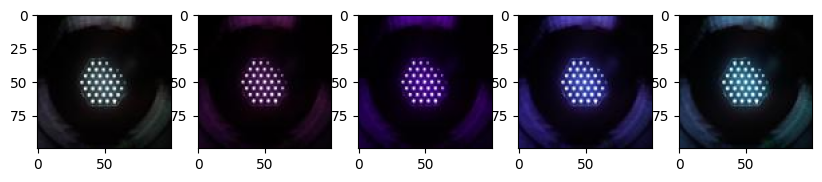

In [10]:
plot_random_images(sample_a)

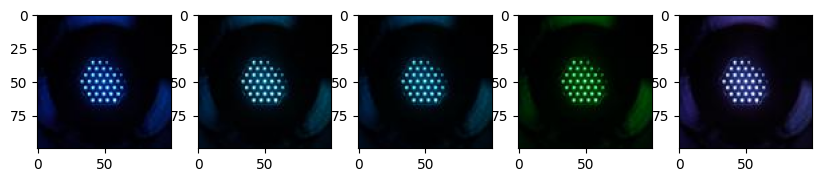

In [11]:
plot_random_images(sample_b)

As you can see, it is quite hard to tell the difference at plain sight. If you look closer, you can notice the difference int the shape of the blur on the top of the image.

That's quite a subtle difference.

<mark style="background-color: #648fff;">Question:</mark> How can we test if these two samples are different? How would you apply the t-test or rank-sum test to solve this problem?

Write down some ideas and we'll brainstorm in class next week.

A general idea can be to use the rank-sum generalized in the bivariate case and use the samples as a probability distribution. So in this case, we sample also a random pixel from the image, and the result of the pixel distribution should be different between the two samples. We can then use the rank-sum to test this phenomena.



Another way is to summarize the important features of the with a function, and use it as a value of the single image. For exemplar, we can test the color intensity in the edges of the image: in particular, we can define a function that compute, for a given image the total intentisity of the color closer to the border and on the top. 

A function like this can be in the form:
$$
f(img)=\sum_{x,y} |(x-50)*(y-50)|\cdot intensity(img[x,y])
$$

In this case the first group of images has a bigger value for the function, while the second has a smaller one, and we can test this value using the t-test.

Next week (project 3) we will build a two-sample test using a neural network. This is a modern approach that you can use to build two-sample tests for virtually any kind of data.

Here is the recommended reading.

> [[Link](https://insightful-data-lab.com/2025/08/23/classifier-two-sample-tests-c2sts/)] A quick bullet-point primer
> 
> [[PDF](https://arxiv.org/pdf/1610.06545)] Lopez-Paz, David, and Maxime Oquab. "Revisiting classifier two-sample tests." arXiv preprint arXiv:1610.06545 (2016).